# Store Item Demand Forecasting

# Motivation for the caselet

Loading and Handling Time Series in Pandas

How to Check Stationarity of a Time Series?

How to make a Time Series Stationary?

Forecasting a Time Series


The objective of this DATASET is to predict 3 months of item-level sales data at different store locations.

File descriptions
train.csv - Training data
test.csv - Test data (Note: the Public/Private split is time based)
sample_submission.csv - a sample submission file in the correct format
Data fields
date - Date of the sale data. There are no holiday effects or store closures.
store - Store ID
item - Item ID
sales - Number of items sold at a particular store on a particular date.

In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [10]:
pwd

'D:\\Stackroute\\TESCO\\Sample codes\\MasterDemo\\XGBoost store demand forecasting'

In [21]:
# Import training and test data
# D:\Stackroute\TESCO\Sample codes\MasterDemo\XGBoost store demand forecasting
#train = pd.read_csv('Data/train.csv')
#test = pd.read_csv('Data/test.csv')

#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')




In [18]:
!pip install statsmodels

You should consider upgrading via the 'c:\users\anirb\anaconda3\envs\py3ds\python.exe -m pip install --upgrade pip' command.


In [19]:

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

color = sns.color_palette()
sns.set_style('darkgrid')

In [20]:
train_df = pd.read_csv("train.csv")
train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [23]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

In [24]:
train_df = expand_df(train_df)
display(train_df)

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


In [25]:
grand_avg = train_df.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

The grand average of sales in this dataset is 52.2503


In [26]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [49]:
train_df.tail(9)

,store,item,sales,day,month,year,dayofweek,forecast
date,,,,,,,,
2017-12-23,10,50,70,23,12,2017,5,0.003821
2017-12-24,10,50,76,24,12,2017,6,0.003845
2017-12-25,10,50,51,25,12,2017,0,0.003880
2017-12-26,10,50,41,26,12,2017,1,0.003899
2017-12-27,10,50,63,27,12,2017,2,0.003892
2017-12-28,10,50,59,28,12,2017,3,0.003870
2017-12-29,10,50,74,29,12,2017,4,0.003852
2017-12-30,10,50,62,30,12,2017,5,0.003849
2017-12-31,10,50,82,31,12,2017,6,0.003861


In [28]:
#Sales by year

agg_year_item = pd.pivot_table(train_df, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train_df, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

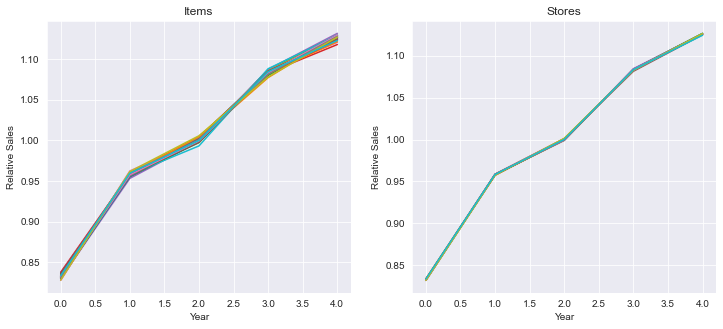

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

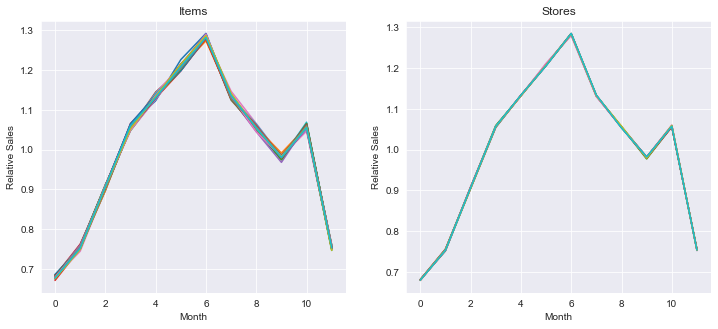

In [30]:
# Now lets check the sales w.r.t. the month

agg_month_item = pd.pivot_table(train_df, index='month', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train_df, index='month', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

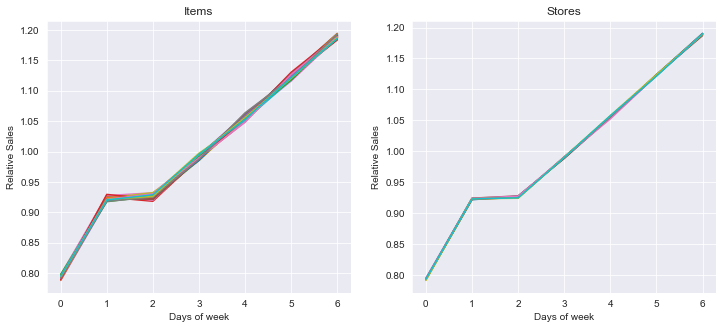

In [31]:
#Sales by days of week

agg_weekly_item = pd.pivot_table(train_df, index='dayofweek', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_weekly_store = pd.pivot_table(train_df, index='dayofweek', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_weekly_item / agg_weekly_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Days of week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_weekly_store / agg_weekly_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Days of week")
plt.ylabel("Relative Sales")
plt.show()

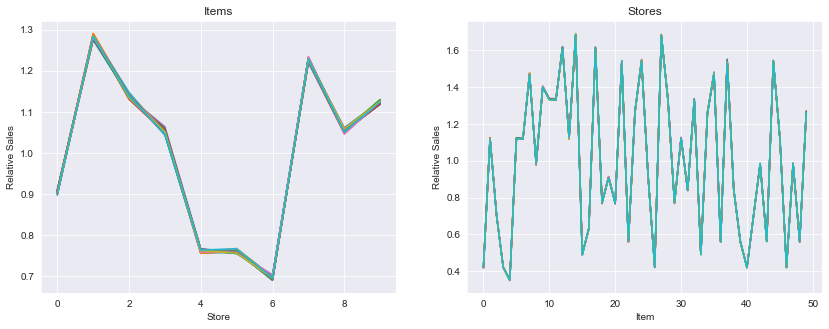

In [32]:
#Also now lets check for item store relationship

agg_store_item = pd.pivot_table(train_df, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

# Time series

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category. When we decompose a time series into components, we usually combine the trend and cycle into a single trend-cycle component (sometimes called the trend for simplicity). Thus we think of a time series comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series).

The Seasonal component: A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. A time series can contain multiple superimposed seasonal periods.

The Trend component: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes a trend is referred to as “changing direction” when it might go from an increasing trend to a decreasing trend.

The Cyclical component: The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. The cyclical component is hard to isolate and it's often ‘left alone’ by combining it with the trend component.

The Noise component: The noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns.

https://towardsdatascience.com/what-is-time-series-decomposition-and-how-does-it-work-9b67e007ae90

<Figure size 432x288 with 0 Axes>

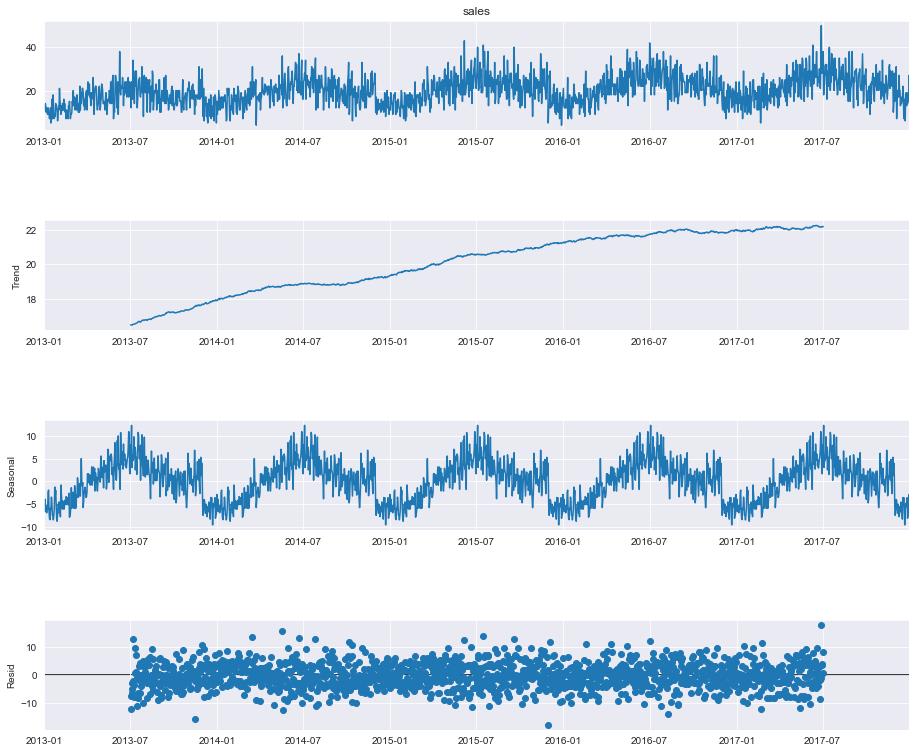

In [34]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train_df[train_df['item']==1]
train_final = train_item1[train_item1['store']==1]

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_final['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

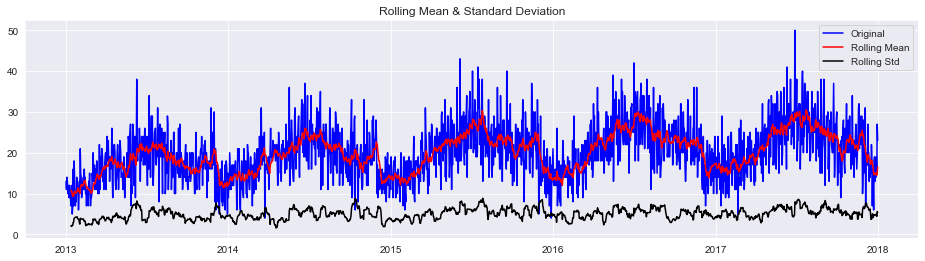

In [35]:
# Rolling Mean Analysis

def roll_stats(timeseries, window = 12, cutoff = 0.01):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
   # plt.rcParams['agg.path.chunksize'] = 50000
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
roll_stats(train_final['sales'])    

In [36]:
# Perform Dickey-Fuller test
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(train_final['sales'])  

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


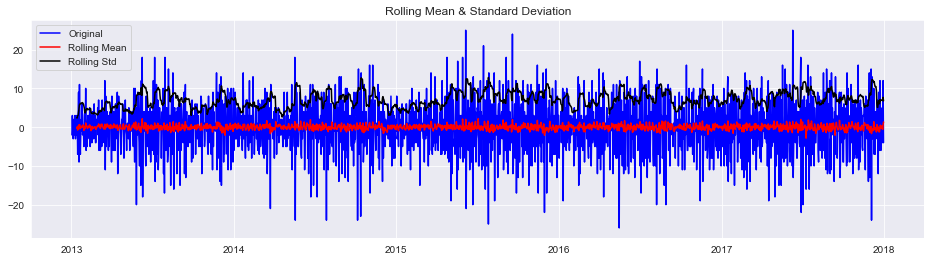

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [37]:
# Make the time series stationary

first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())
roll_stats(first_diff,window = 12, cutoff = 0.01)
dickey_fuller_test(first_diff, window = 12)

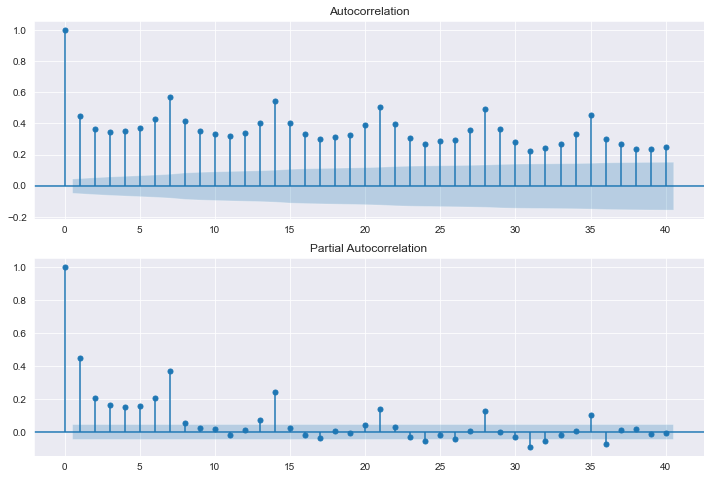

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_final.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_final.sales, lags=40, ax=ax2)# , lags=40

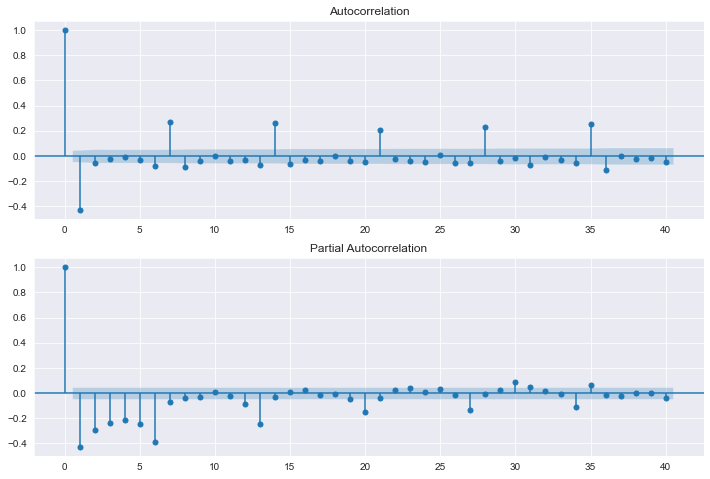

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)

Reference: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# How to find the order of the AR term (p)

You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

In [41]:
arima_model = sm.tsa.ARIMA(train_final.sales, (6,1,0)).fit(disp=False)
print(arima_model.summary())

C:\Users\anirb\anaconda3\envs\PY3DS\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\anirb\anaconda3\envs\PY3DS\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Wed, 24 Mar 2021   AIC                          11211.335
Time:                        10:52:54   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

NormaltestResult(statistic=16.42638879596088, pvalue=0.0002710534841743061)


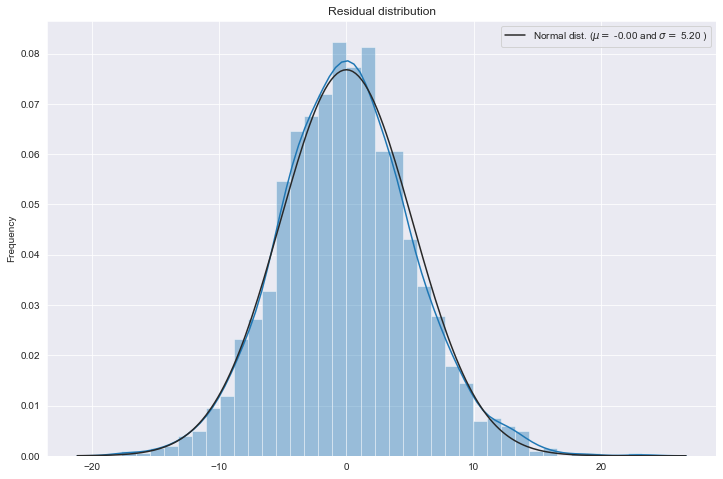

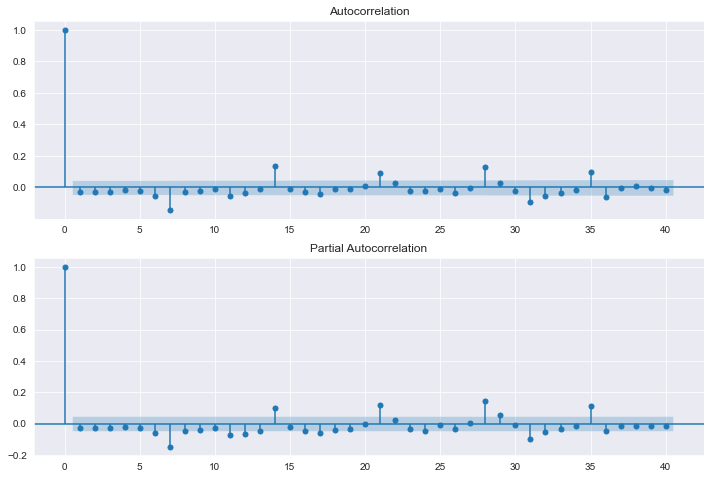

In [44]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

<AxesSubplot:xlabel='date'>

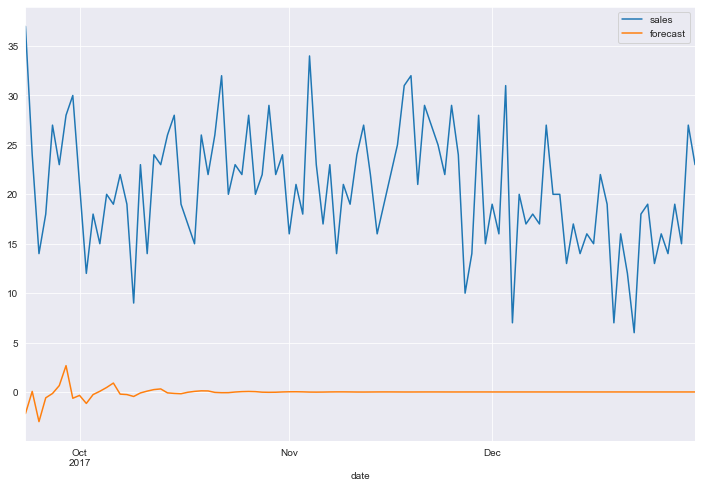

In [45]:
start_index = 1726
end_index = 1826
train_df['forecast'] = arima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [46]:
# Now we will use SARIMAX

sarima_model = sm.tsa.statespace.SARIMAX(train_final.sales, trend='n', order=(6,1,0)).fit()
print(sarima_model.summary())

C:\Users\anirb\anaconda3\envs\PY3DS\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\anirb\anaconda3\envs\PY3DS\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 24 Mar 2021   AIC                          11209.359
Time:                        10:54:23   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690144094457, pvalue=0.00023140408914196838)


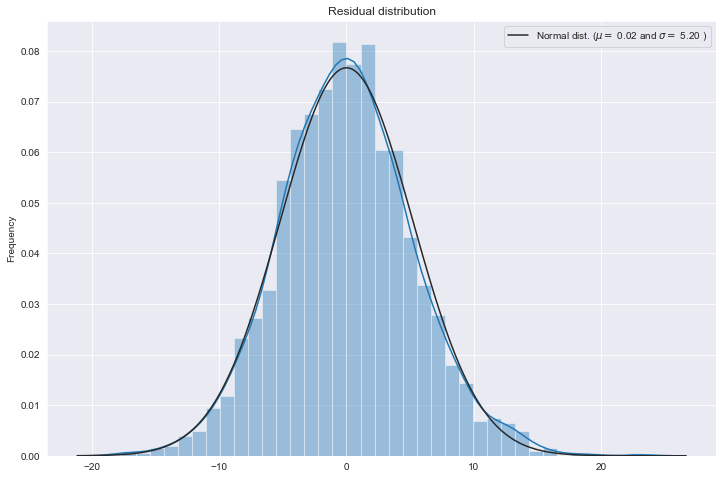

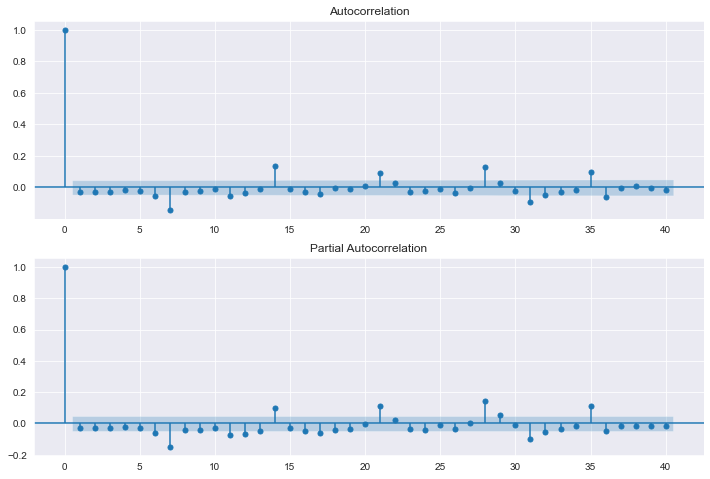

In [47]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)